In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_linnerud
from tsai.all import *

epochs = 150

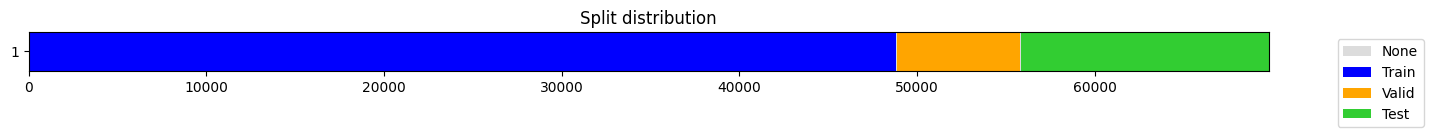

((69861, 35),
 (69861, 1),
 ((#48837) [0,1,2,3,4,5,6,7,8,9...],
  (#6977) [48848,48849,48850,48851,48852,48853,48854,48855,48856,48857...],
  (#13954) [55836,55837,55838,55839,55840,55841,55842,55843,55844,55845...]))

In [6]:
df = pd.read_csv("data/merged_fill.csv")
# df.describe().T.to_csv("describe_merged.csv")
import json
with open("data/meta.json", "r") as f:
    meta = json.load(f)
X_cols = list(meta["control"].keys())

y_cols = ["INNER_TPRT_1"] 
# X_cols.remove(y_cols[0])
X_raw = df[X_cols]
X, y = df[X_cols].to_numpy(), df[y_cols].to_numpy()

datetime_col = "MSRM_DT"
fcst_history = 60 # # steps in the past
fcst_horizon = 12  # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

splits = get_forecasting_splits(
    df, fcst_history=fcst_history, 
    fcst_horizon=fcst_horizon, datetime_col=datetime_col,
    valid_size=valid_size, test_size=test_size
)

X.shape, y.shape, splits

TSTensor(samples:64, vars:1, len:35, device=cuda:0, dtype=torch.float32)


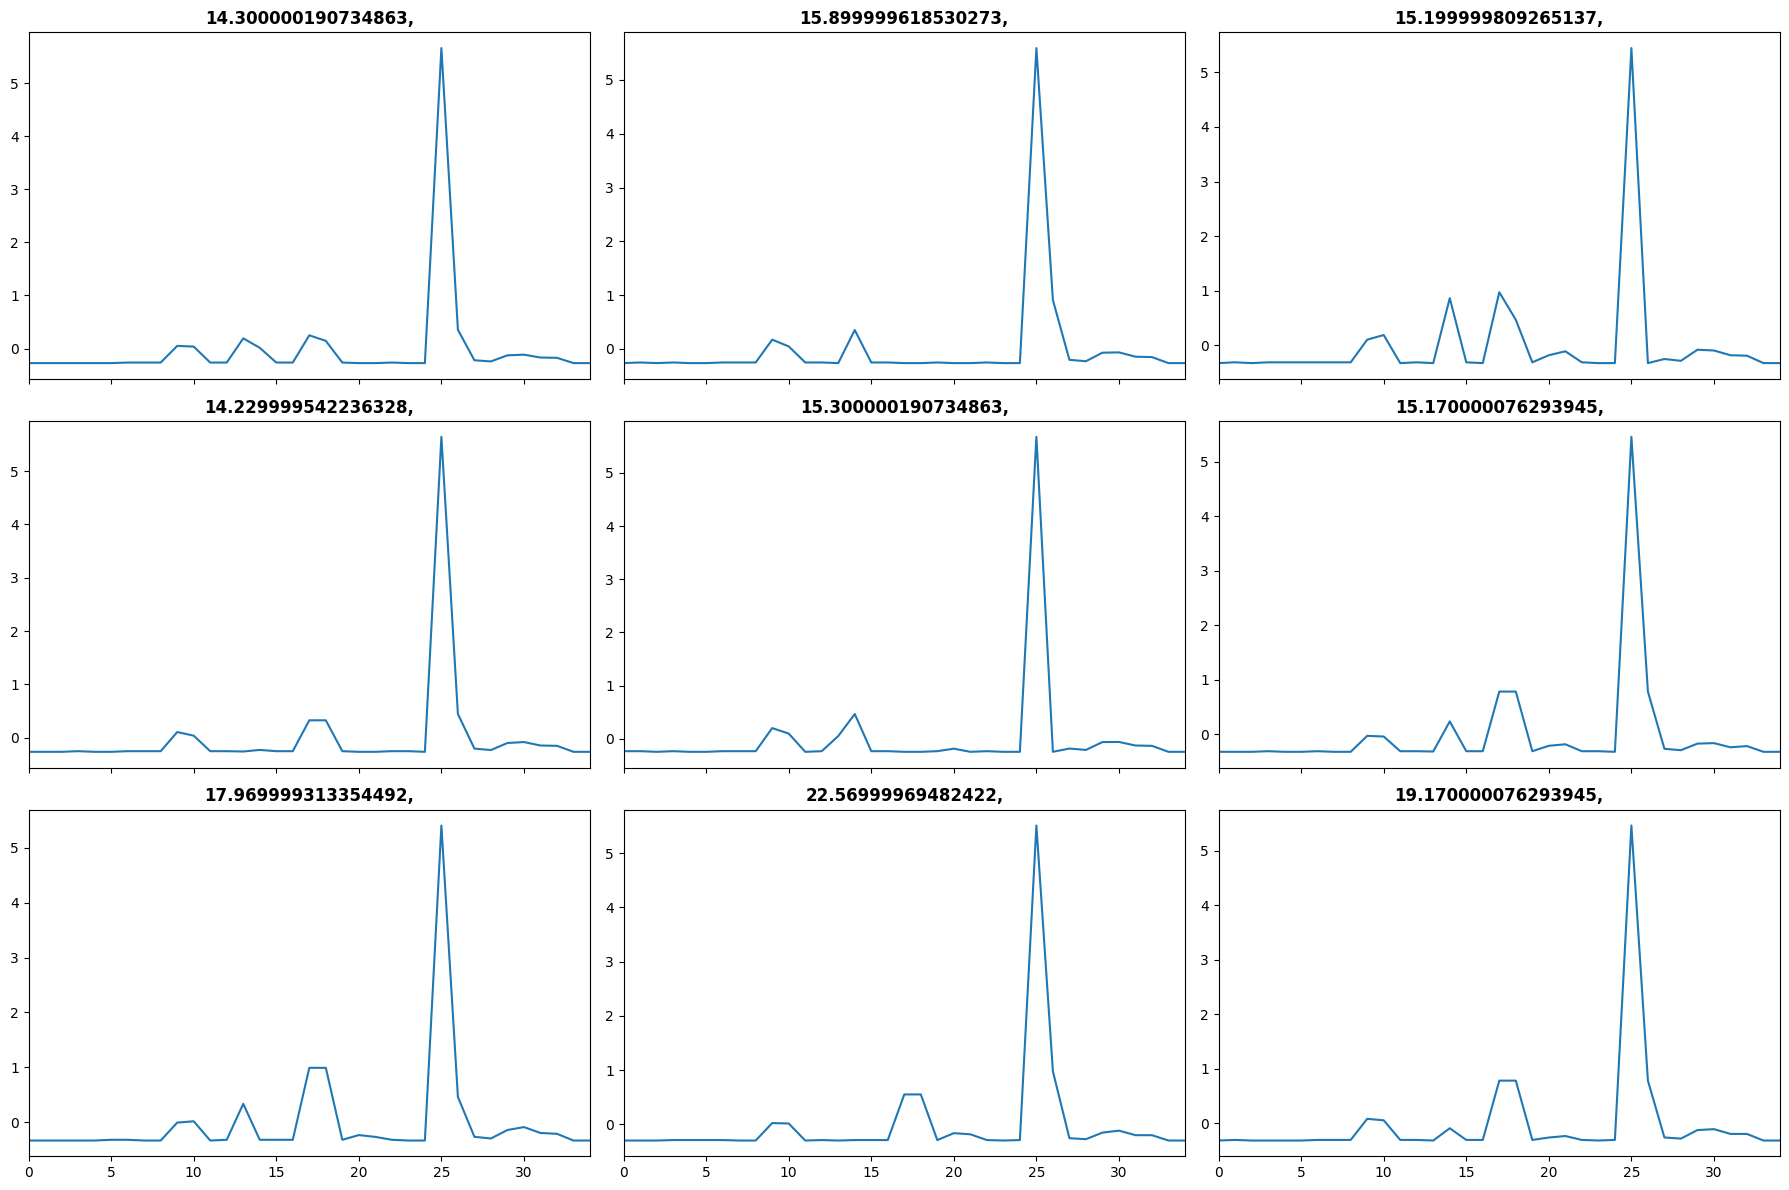

In [7]:
tfms = [None, TSRegression()]
batch_tfms = [
    TSStandardize(by_sample=True),
    # TSNormalize(), TSToPlot(),
    # TSNormalize(), TSToMat(),
    # TSNormalize(), TSToGADF()
]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, 
    batch_tfms=batch_tfms)
    
print(dls.one_batch()[0])
dls.show_batch()


arch: PatchTST(c_in=1 c_out=1 seq_len=35 pred_dim=1 arch_config={}, kwargs={})


epoch,train_loss,valid_loss,mse,time
0,5.771420,17.161987,17.161987,00:04
1,4.280484,13.753675,13.753675,00:04
2,3.435078,15.254481,15.254481,00:04
3,2.990058,6.167881,6.167881,00:04
4,2.709416,8.655884,8.655884,00:04
5,2.592258,7.541132,7.541132,00:04
6,2.391777,5.158806,5.158806,00:04
7,2.261588,8.489686,8.489686,00:04
8,2.027389,4.980736,4.980736,00:04
9,1.946744,4.840963,4.840963,00:04


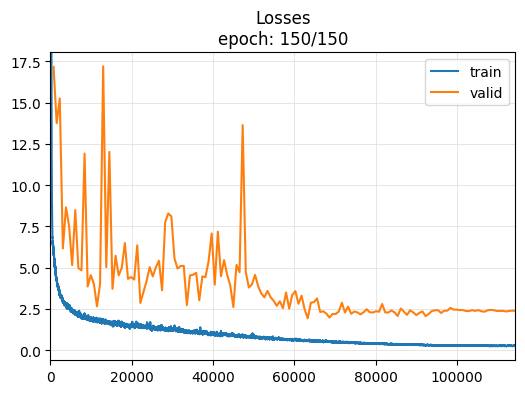

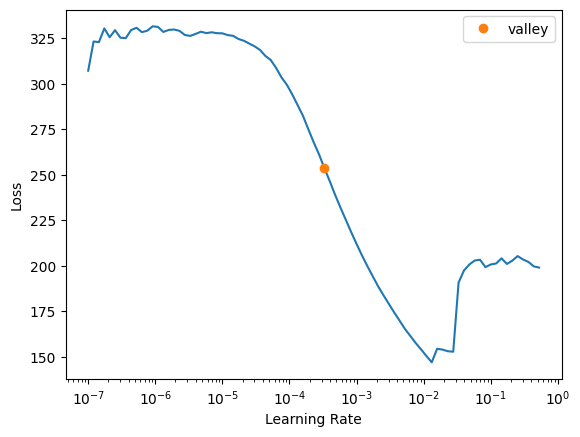

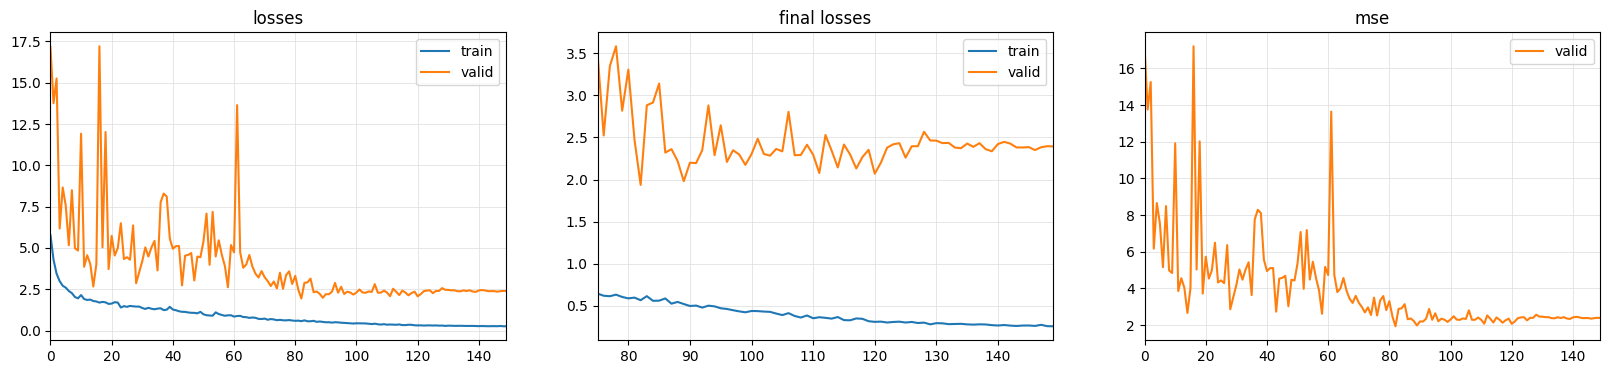

In [8]:
# 35min

reg = TSRegressor(
    X, y, splits=splits, 
    path='model_file', arch="PatchTST", 
    tfms=tfms, batch_tfms=batch_tfms, 
    metrics=[mse], cbs=ShowGraph(), verbose=True
)
lr = reg.lr_find()
reg.fit_one_cycle(epochs, lr)
reg.export("reg.pkl")


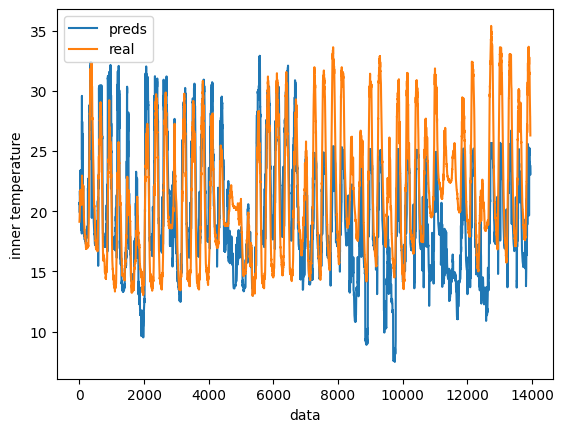

In [11]:
from tsai.inference import load_learner

learn = load_learner("model_file/reg.pkl", cpu=False)

raw_preds, _, preds = learn.get_X_preds(
    X[splits[2]].reshape(1, -1, len(X_cols))
)

# Test data
plt.plot(preds[0], label="preds")
plt.plot(y[splits[2]], label="real")
plt.xlabel("data")
plt.ylabel("inner temperature")
plt.legend()


In [12]:
X[0]

array([  1.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,
         1.  ,  25.25,  35.2 ,   0.  ,   0.  , 100.  , 100.  ,   1.  ,
         0.  , 100.  , 100.  ,   1.  , 100.  , 100.  ,   0.  ,   0.  ,
         0.  ,   0.  , 110.  ,   5.3 ,   3.3 ,  23.5 ,  20.  ,  10.85,
         7.5 ,   0.  ,   0.  ])

In [13]:
X[splits[1]].reshape(1, -1, len(X_cols)).shape, len(preds[0]), len(raw_preds[0])

((1, 6977, 35), 13954, 13954)

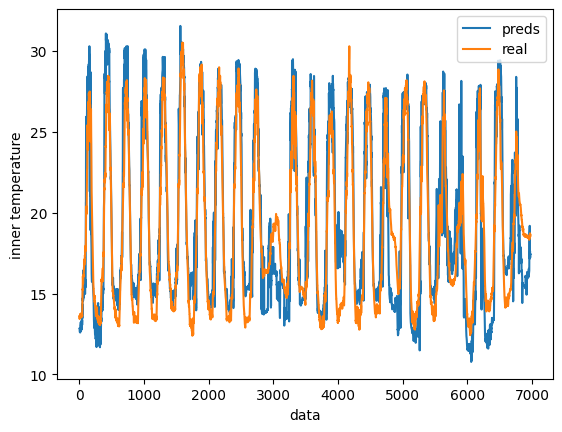

In [14]:
# validation data
raw_preds, _, preds = learn.get_X_preds(
    X[splits[1]].reshape(1, -1, len(X_cols))
)

plt.plot(preds[0], label="preds")
plt.plot(y[splits[1]], label="real")
plt.xlabel("data")
plt.ylabel("inner temperature")
plt.legend()

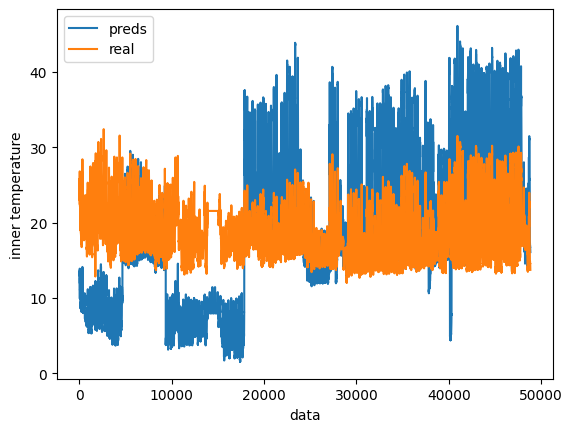

In [15]:
# train data
raw_preds, _, preds = learn.get_X_preds(
    X[splits[0]].reshape(1, -1, len(X_cols))
)
plt.plot(preds[0], label="preds")
plt.plot(y[splits[0]], label="real")
plt.xlabel("data")
plt.ylabel("inner temperature")
plt.legend()